# **BARISTA TIPS PREDICTION**

Sebagai implementasi materi Linear Regression pada Machine Learning, saya menggunakan dataset Barista Tips untuk memprediksi "Tips" yang didapatkan seorang barista berdasarkan features sebagai variable pendukung. Dataset berikut berisi kolom-kolom:
1. Tips : Uang yang didapatkan seorang barista
2. Day of Week : Hari bekerja
3. Hours Worked : Lama Waktu bekerja (jam)
4. Shift Start Time : Jam mulai bekerja pada hari itu
5. Shift End Time : Jam selesai bekerja pada hari itu
6. Dollar/Hour : Upah yang didapatkan per-jam. 

Sebelum melakukan prediksi, hal pertama yang harus dilakukan ialah melakukan import library sesuai dengan kebutuhan data. Lalu load data yang akan dianalisis.

In [32]:
#Import Library

import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [33]:
#Load Data

barista = pd.read_csv('Project Data - Sheet1.csv')
barista.head() #menampilkan 5 baris teratas

,Tips,Day of Week,Hours Worked,Shift Start Time,Shift End Time,Dollar/Hour
0,63,Mon,8,7,15,7.875000
1,58,Tue,8,7,15,7.250000
2,28,Wed,6,10,16,4.666667
3,32,Thu,6,10,16,5.333333
4,34,Fri,7,9,16,4.857143


### **Data Cleaning**

In [34]:
#Mengecek informasi dataset seperti tipe data per-kolom
barista.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Tips              49 non-null     int64  
 1   Day of Week       49 non-null     object 
 2   Hours Worked      49 non-null     int64  
 3   Shift Start Time  49 non-null     int64  
 4   Shift End Time    49 non-null     int64  
 5   Dollar/Hour       49 non-null     float64
dtypes: float64(1), int64(4), object(1)
memory usage: 2.4+ KB


In [35]:
#Mengecek missing value 
barista.isna().sum()

Tips                0
Day of Week         0
Hours Worked        0
Shift Start Time    0
Shift End Time      0
Dollar/Hour         0
dtype: int64

In [36]:
#Mengecek Duplicate Value
barista[barista.duplicated()]

,Tips,Day of Week,Hours Worked,Shift Start Time,Shift End Time,Dollar/Hour
29,62,Tue,8,7,15,7.750000
33,29,Sat,7,9,16,4.142857
34,26,Sun,7,9,16,3.714286
43,58,Tue,8,7,15,7.250000
44,29,Wed,6,10,16,4.833333
47,30,Sat,7,9,16,4.285714


Terdapat duplikasi data. Namun dilihat dahulu distribusi data dan outliersnya. Jika sangat jauh dari nilai tengah maka akan di drop.

In [48]:
#Menampilkan nama kolom, tipe data, jumlah unique value, dan unique valuee

list_data = []
for i in barista.columns :
    list_data.append([
        i, #nama kolom
        barista[i].dtype, #tipe data dari setiap kolom
        barista[i].nunique(), #jumlah unique value 
        list(barista[i].drop_duplicates().sample(2).values) #unique values
    ])

pd.DataFrame(list_data, columns = ['Columns', 'Tipe Data', 'N Unique', 'Unique Sample'])

,Columns,Tipe Data,N Unique,Unique Sample
0,Tips,int64,28,"[37, 30]"
1,Day of Week,object,7,"[Tue, Sun]"
2,Hours Worked,int64,3,"[6, 7]"
3,Shift Start Time,int64,3,"[9, 7]"
4,Shift End Time,int64,2,"[15, 16]"
5,Dollar/Hour,float64,31,"[7.25, 4.428571429]"


### **Simple EDA**

#### **Menampilkan Distribusi Data dan Outliers**

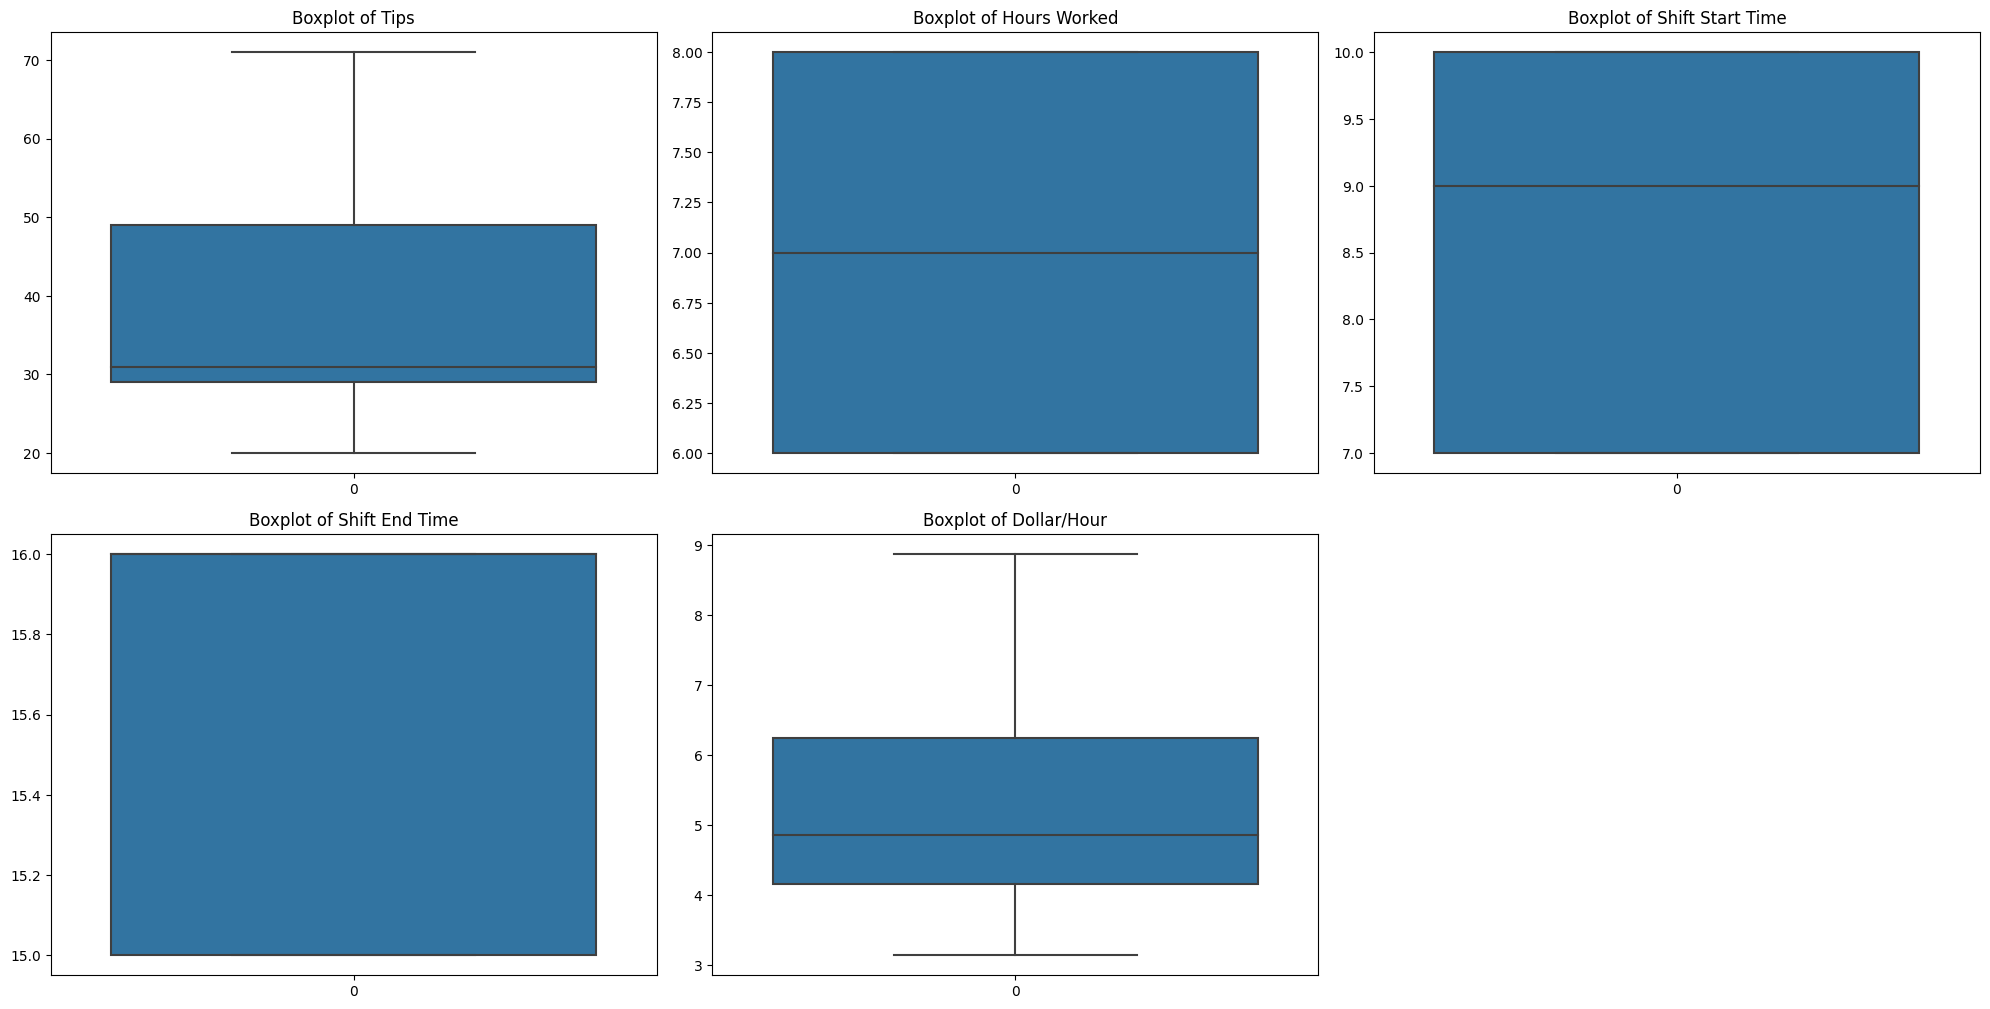

In [45]:
#Membuat variable yang berisi variable numerik
data = barista[['Tips','Hours Worked','Shift Start Time','Shift End Time','Dollar/Hour']]

#Membuat kanvas grafik
plt.figure(figsize=(20,20))

#Code Utama
for i, column in enumerate(data,1):
    plt.subplot(4,3,i)
    sns.boxplot(data= barista[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

Dari tampilan 5 boxplot diatas, bisa dilihat tidak terdapat outlier pada kolom-kolom numerik. Namun perlu dilakukan uji normalitas untuk memastikan apakah data terdistribusi normal atau tidak.

#### **Uji Normalitas pada Kolom Numerik**

In [52]:
#Import Library untuk uji Normalitas
from scipy.stats import kstest

#List kosong untuk menaruh hasil uji distribusi setiap kolom
list_distribusi = []

#Melakukan looping uji normalitas untuk setiap kolom yang sudah ditaruh dalam list feature_column
for i in data : 
    ks,pvalue = kstest((barista[i]), 'norm')
    if pvalue> 0.05:
        list_distribusi.append([i,round(pvalue,2), 'distribusi normal'])
    else :
        list_distribusi.append([i,round(pvalue,2), 'distribusi tidak normal'])

print('Jika p-value > 0,05 maka data terdistribusi normal')
print('Jika p-value < 0,05 maka data terdistribusi tidak normal')
print(f'\n')
print('Hasil Uji Normalitas')
pd.DataFrame(list_distribusi, columns =[['Nama kolom','p-value','Distribusi']])

Jika p-value > 0,05 maka data terdistribusi normal
Jika p-value < 0,05 maka data terdistribusi tidak normal


Hasil Uji Normalitas


,Nama kolom,p-value,Distribusi
0,Tips,0.0,distribusi tidak normal
1,Hours Worked,0.0,distribusi tidak normal
2,Shift Start Time,0.0,distribusi tidak normal
3,Shift End Time,0.0,distribusi tidak normal
4,Dollar/Hour,0.0,distribusi tidak normal


Berdasarkan hasil uji normalitas diatas, diketahui data-data pada kolom 'Tips','Hours Worked','Shift Start Time','Shift End Time','Dollar/Hour' **terdistribusi tidak normal**.

#### **Uji Korelasi Antar Kolom**

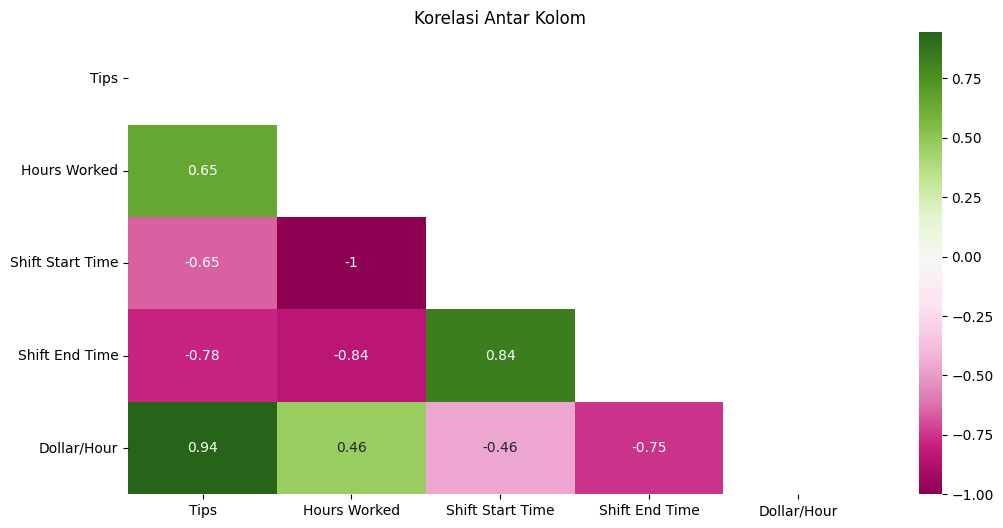

In [54]:
#Membuat Canvas Plot
plt.figure(figsize=(12,6))

#memfilter agar tidak ada duplikasi pada korelasi antar kolom yang ditampilkan
matrix = np.triu(data.corr('spearman'))

#Visualisasi Korelasi antar Kolom
sns.heatmap(
    data=data.corr('spearman'), 
    annot=True,  #menampilkan nilai korelasinya
    mask=matrix, #untuk menampilkan salah satu sisi korelasinya saja
    cmap='PiYG' #customize warna heatmap
)

#Menampilkan Judul 
plt.title('Korelasi Antar Kolom')

#Menampilkan grafik
plt.show()

Berdasarkan uji korelasi antar kolom dengan Heatmap, maka hasil yang diperoleh:
 - Korelasi positif berada pada range 0,46 hingga 0,94.
 - Korelasi negatif berada pada range -0,46 hingga -1. 

#### **Menampilkan Korelasi Antara Dollar/Hour dengan Tips dengan Scatterplot**

<Axes: xlabel='Dollar/Hour', ylabel='Tips'>

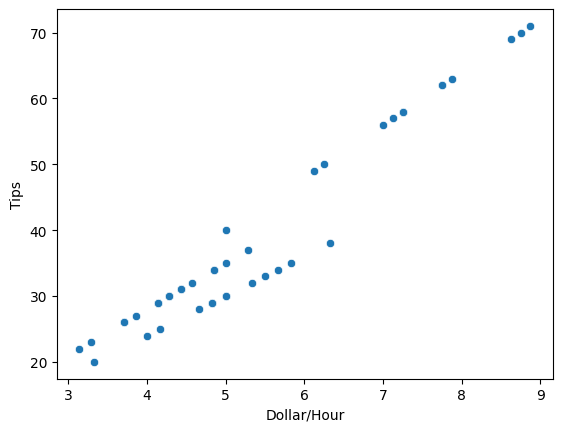

In [39]:
#Melihat korelasi antara Dollar/Hour dengan Tips dengan Scatterplot
sns.scatterplot(data=barista, x=barista['Dollar/Hour'], y=barista['Tips'])

Hubungan antara Dollar/Hour dengan Tips adalah positif.

### **Regression Model**

#### **Simple Regression Model**

In [55]:
#Memprediksi 'Tips' yang didapat seorang barista berdasarkan faktor 'Dollar/Hour'

reg_model1 = sm.OLS(barista['Tips'], sm.add_constant(barista['Dollar/Hour']))
hasil = reg_model1.fit()
print(hasil.summary())

                            OLS Regression Results                            
Dep. Variable:                   Tips   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     756.2
Date:                Mon, 18 Sep 2023   Prob (F-statistic):           1.28e-30
Time:                        21:53:25   Log-Likelihood:                -130.35
No. Observations:                  49   AIC:                             264.7
Df Residuals:                      47   BIC:                             268.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -10.6405      1.838     -5.789      

Berdasarkan hasil summary diatas, maka dapar dilihat:
1. **R-squared : 0.941**
    - artinya, Nilai Dollar/Hour mempengaruhi Tips sebesar 94,1%.
2. **Prob (F-statistic): 1.28e-30**
    - Berdasarkan hasil uji Anova, maka hipotesisnya adalah :
        - H0 = beta tidak berpengaruh signifikan terhadap model (beta=0), p-value > 0,05.
        - H1 = beta berpengaruh signifikan terhadap model (beta!=0), p-value < 0,05.
    - Hasil uji Anova diatas menunjukkan p-value < 0,05 maka tolak H0, atau dapat dikatakan beta berpengaruh signifikan terhadap model.

In [56]:
#Prediksi Tips yang diperoleh berdasarkan Uji Simple Regression diatas

def model(x) :
    Y = -10.6405 + (9.1268*x)
    return Y

print(f'tips yang diperoleh bila Dollar/Hour 10 adalah {model(10)}') #bila Dollar/Hour 10

tips yang diperoleh bila Dollar/Hour 10 adalah 80.6275


#### **Multiple Regression Model**

In [57]:
#Memprediksi 'Tips' yang didapat seorang barista berdasarkan faktor 'Hours Worked' dan 'Dollar/Hour'

reg_model2 = sm.OLS(barista['Tips'], sm.add_constant(barista[['Hours Worked','Dollar/Hour']]))
hasil = reg_model2.fit()
print(hasil.summary())

                            OLS Regression Results                            
Dep. Variable:                   Tips   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     9748.
Date:                Mon, 18 Sep 2023   Prob (F-statistic):           3.56e-61
Time:                        22:10:22   Log-Likelihood:                -51.629
No. Observations:                  49   AIC:                             109.3
Df Residuals:                      46   BIC:                             114.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -40.9150      0.987    -41.458   

Berdasarkan hasil summary diatas, maka dapar dilihat:
1. **R-squared : 0.998**
    - artinya, Nilai Dollar/Hour mempengaruhi Tips sebesar 99,8%.
2. **Prob (F-statistic): 3.56e-61**
    - Berdasarkan hasil uji Anova, maka hipotesisnya adalah :
        - H0 = beta tidak berpengaruh signifikan terhadap model (beta=0), p-value > 0,05.
        - H1 = beta berpengaruh signifikan terhadap model (beta!=0), p-value < 0,05.
    - Hasil uji Anova diatas menunjukkan p-value < 0,05 maka tolak H0, atau dapat dikatakan beta berpengaruh signifikan terhadap model.

In [59]:
#Prediksi Tips yang diperoleh berdasarkan Uji Multiple Regression diatas

def model(x1,x2) :
    Y = -40.9150 + (5.5817*x1) + (7.4746*x2)
    return Y

print(f'Tips yang diperoleh bila Waktu bekerja (Hours Worked) selama 5 jam dengan Dollar/Hour sebesar 2 adalah {model(5,2)}')

Tips yang diperoleh bila Waktu bekerja (Hours Worked) selama 5 jam dengan Dollar/Hour sebesar 2 adalah 1.9426999999999968
